In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython.display import clear_output
from datetime import datetime

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-07-05 00:14:11.633122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def read_files(freq, fn):
    df_hr = pd.read_csv(fn+'_hr.csv', parse_dates=['datetime'], index_col=['datetime'])
    df_hr = df_hr.resample(freq).mean(numeric_only=True)
    
    df_steps = pd.read_csv(fn+'_steps.csv', parse_dates=['datetime'], index_col=['datetime'])
    df_steps = df_steps.resample(freq).sum(numeric_only=True)
    
    df = pd.merge(df_hr, df_steps, left_index=True, right_index=True)
    del[df_hr, df_steps]
    
    df = df[['steps','heartrate']]
    df = df.dropna()
    df = df.reset_index()
    df.drop(columns=['datetime'], inplace=True)
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    
    limits = df.apply(lambda x: pd.Series([x.min(), x.max()])).T.values.tolist()

    return df, limits

In [3]:
class DataConversion:
    def __init__(self, limit, low=0.0, high=1.0):
        self.limit = limit
        if low>high:
            low, high = high, low
        self.low = low
        self.high = high
        print(low, high)
        
        
    def __getNewValue__(self, x, newMin, newMax, oldMin, oldMax):
        return newMin+(((x-oldMin)*(newMax-newMin))/(oldMax-oldMin))
        
    def convertToNewRange(self, X):
        X_new = X.copy()
        X_new = X_new.astype(np.float32)

        for d in range(np.size(X_new, 1)):
            minf, maxf = self.limit[d][0], self.limit[d][1]
            X_new[:, d] = [self.__getNewValue__(x, self.low, self.high, minf, maxf) for x in X_new[:, d]]

        return X_new 
    
    def revertToOriginalValue(self, X):
        X_new = X.copy()
        X_new = X_new.astype(np.float32)

        for d in range(np.size(X_new, 1)):
            minf, maxf = self.limit[d][0], self.limit[d][1]
            X_new[:, d] = [self.__getNewValue__(x, minf, maxf, self.low, self.high) for x in X_new[:, d]]

        return X_new

In [4]:
class Sampling(layers.Layer):
    def call(self, inputs):
        Z_mu, Z_log_sigma = inputs
        batch = tf.shape(Z_mu)[0]
        dim = tf.shape(Z_mu)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return Z_mu+tf.exp(0.5*Z_log_sigma)*epsilon


class VAE(keras.Model):
    def __init__(self, input_dim, latent_dim, C=1.0, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.output_dim = input_dim
        self.latent_dim = latent_dim
        self.C = C
        self.encoder = self.__encoder__()
        self.decoder = self.__decoder__()
        self.total_loss = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss = keras.metrics.Mean(name='kl_loss')
    
    def __encoder__(self):
        encode_input = keras.Input(shape=self.input_dim)
        dense_layer = keras.layers.Dense(16, activation='relu')(encode_input)
        Z_mu = keras.layers.Dense(self.latent_dim, name='Z_mu')(dense_layer)
        Z_log_sigma = keras.layers.Dense(self.latent_dim, name='Z_sigma')(dense_layer)
        Z = Sampling()([Z_mu, Z_log_sigma])
        model = keras.Model(encode_input, [Z_mu, Z_log_sigma, Z], name='encoder')
        return model

    def __decoder__(self):
        decoder_input = keras.Input(shape=self.latent_dim)
        dense_layer = keras.layers.Dense(25, activation='relu')(decoder_input)
        output_layer = keras.layers.Dense(self.output_dim, activation='sigmoid')(dense_layer)
        model = keras.Model(decoder_input, output_layer, name='decoder')
        return model

    @property
    def metrics(self):
        return [
            self.total_loss,
            self.reconstruction_loss,
            self.kl_loss
        ]
    
    def train_step(self, data):
        #print(data.shape)
        with tf.GradientTape() as tape:
            z_mu, z_log_sigma, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=0
                )
            )
            
            kl_loss = -0.5*(1+z_log_sigma-tf.square(z_mu)-tf.exp(z_log_sigma))
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(kl_loss, axis=1)
            )
            
            total_loss = reconstruction_loss + (self.C*kl_loss)
            #print('Total loss=',total_loss.numpy())
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        #print('Total loss=',total_loss.numpy())
        #print('Reconstruction loss=',reconstruction_loss.numpy())
        #print('KL loss=',kl_loss.numpy())
        
        self.total_loss.update_state(total_loss)
        self.reconstruction_loss.update_state(reconstruction_loss)
        self.kl_loss.update_state(kl_loss)
        return {
            'loss': self.total_loss.result(),
            'reconstruction_loss': self.reconstruction_loss.result(),
            'kl_loss': self.kl_loss.result()
        }

[[0.0, 1831.0], [50.391891891891895, 131.03886010362694]]


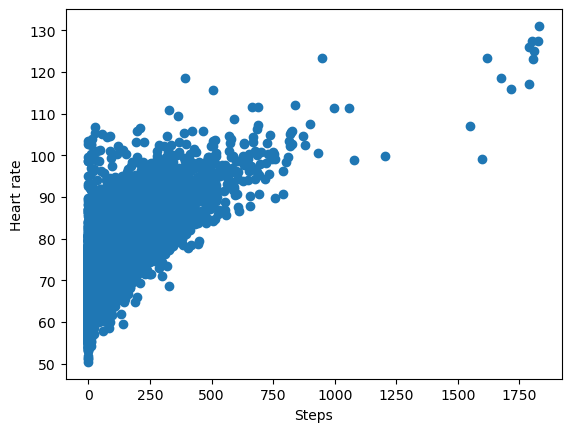

steps        0
heartrate    0
dtype: int64


,steps,heartrate
0,360,90.282443
1,223,81.228346
2,86,79.385965
3,0,76.934959
4,0,75.421687


In [7]:
user = 'AFPB8J2'
path = f'../../../Data/COVID-19-Wearables/{user}'
df, limits = read_files('15min', path)
print(limits)

plt.scatter(df.steps, df.heartrate)
plt.xlabel('Steps')
plt.ylabel('Heart rate')
plt.show()

#start = df.datetime.min()

def getDurationInMin(t1, t2):
    t1 = pd.to_datetime(t1)
    t2 = pd.to_datetime(t2)
    
    if t1>t2:
        t1,t2=t2,t1
        
    t = t2-t1
    return round(t.total_seconds()/60, 2)

#df['TimeSteps'] = [getDurationInMin(start, t) for t in df.datetime]
print(df.isnull().sum())
df.head()

In [8]:
data = df.to_numpy()
print(data.shape)

limits = []
for d in range(np.size(data, 1)):
    limits.append((min(data[:, d]), max(data[:, d])))
    
limits

(6599, 2)


[(0.0, 1831.0), (50.391891891891895, 131.03886010362694)]

In [10]:
dc = DataConversion(limits)
train_df = dc.convertToNewRange(data)
for d in range(np.size(train_df, 1)):
    print((min(train_df[:, d]), max(train_df[:, d])))

0.0 1.0
(0.0, 1.0)
(-5.113642e-09, 1.0)


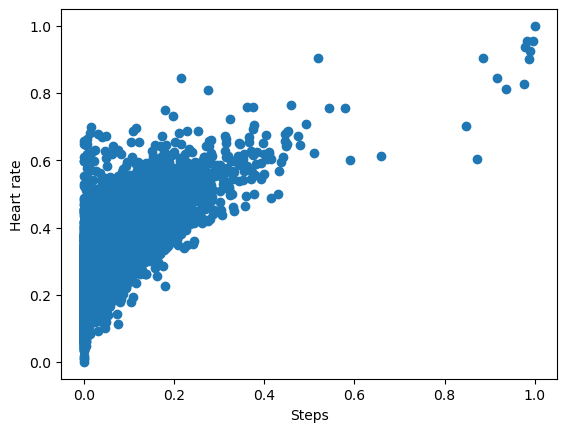

In [11]:
plt.scatter(train_df[:,0], train_df[:,1])
plt.xlabel('Steps')
plt.ylabel('Heart rate')
plt.show()

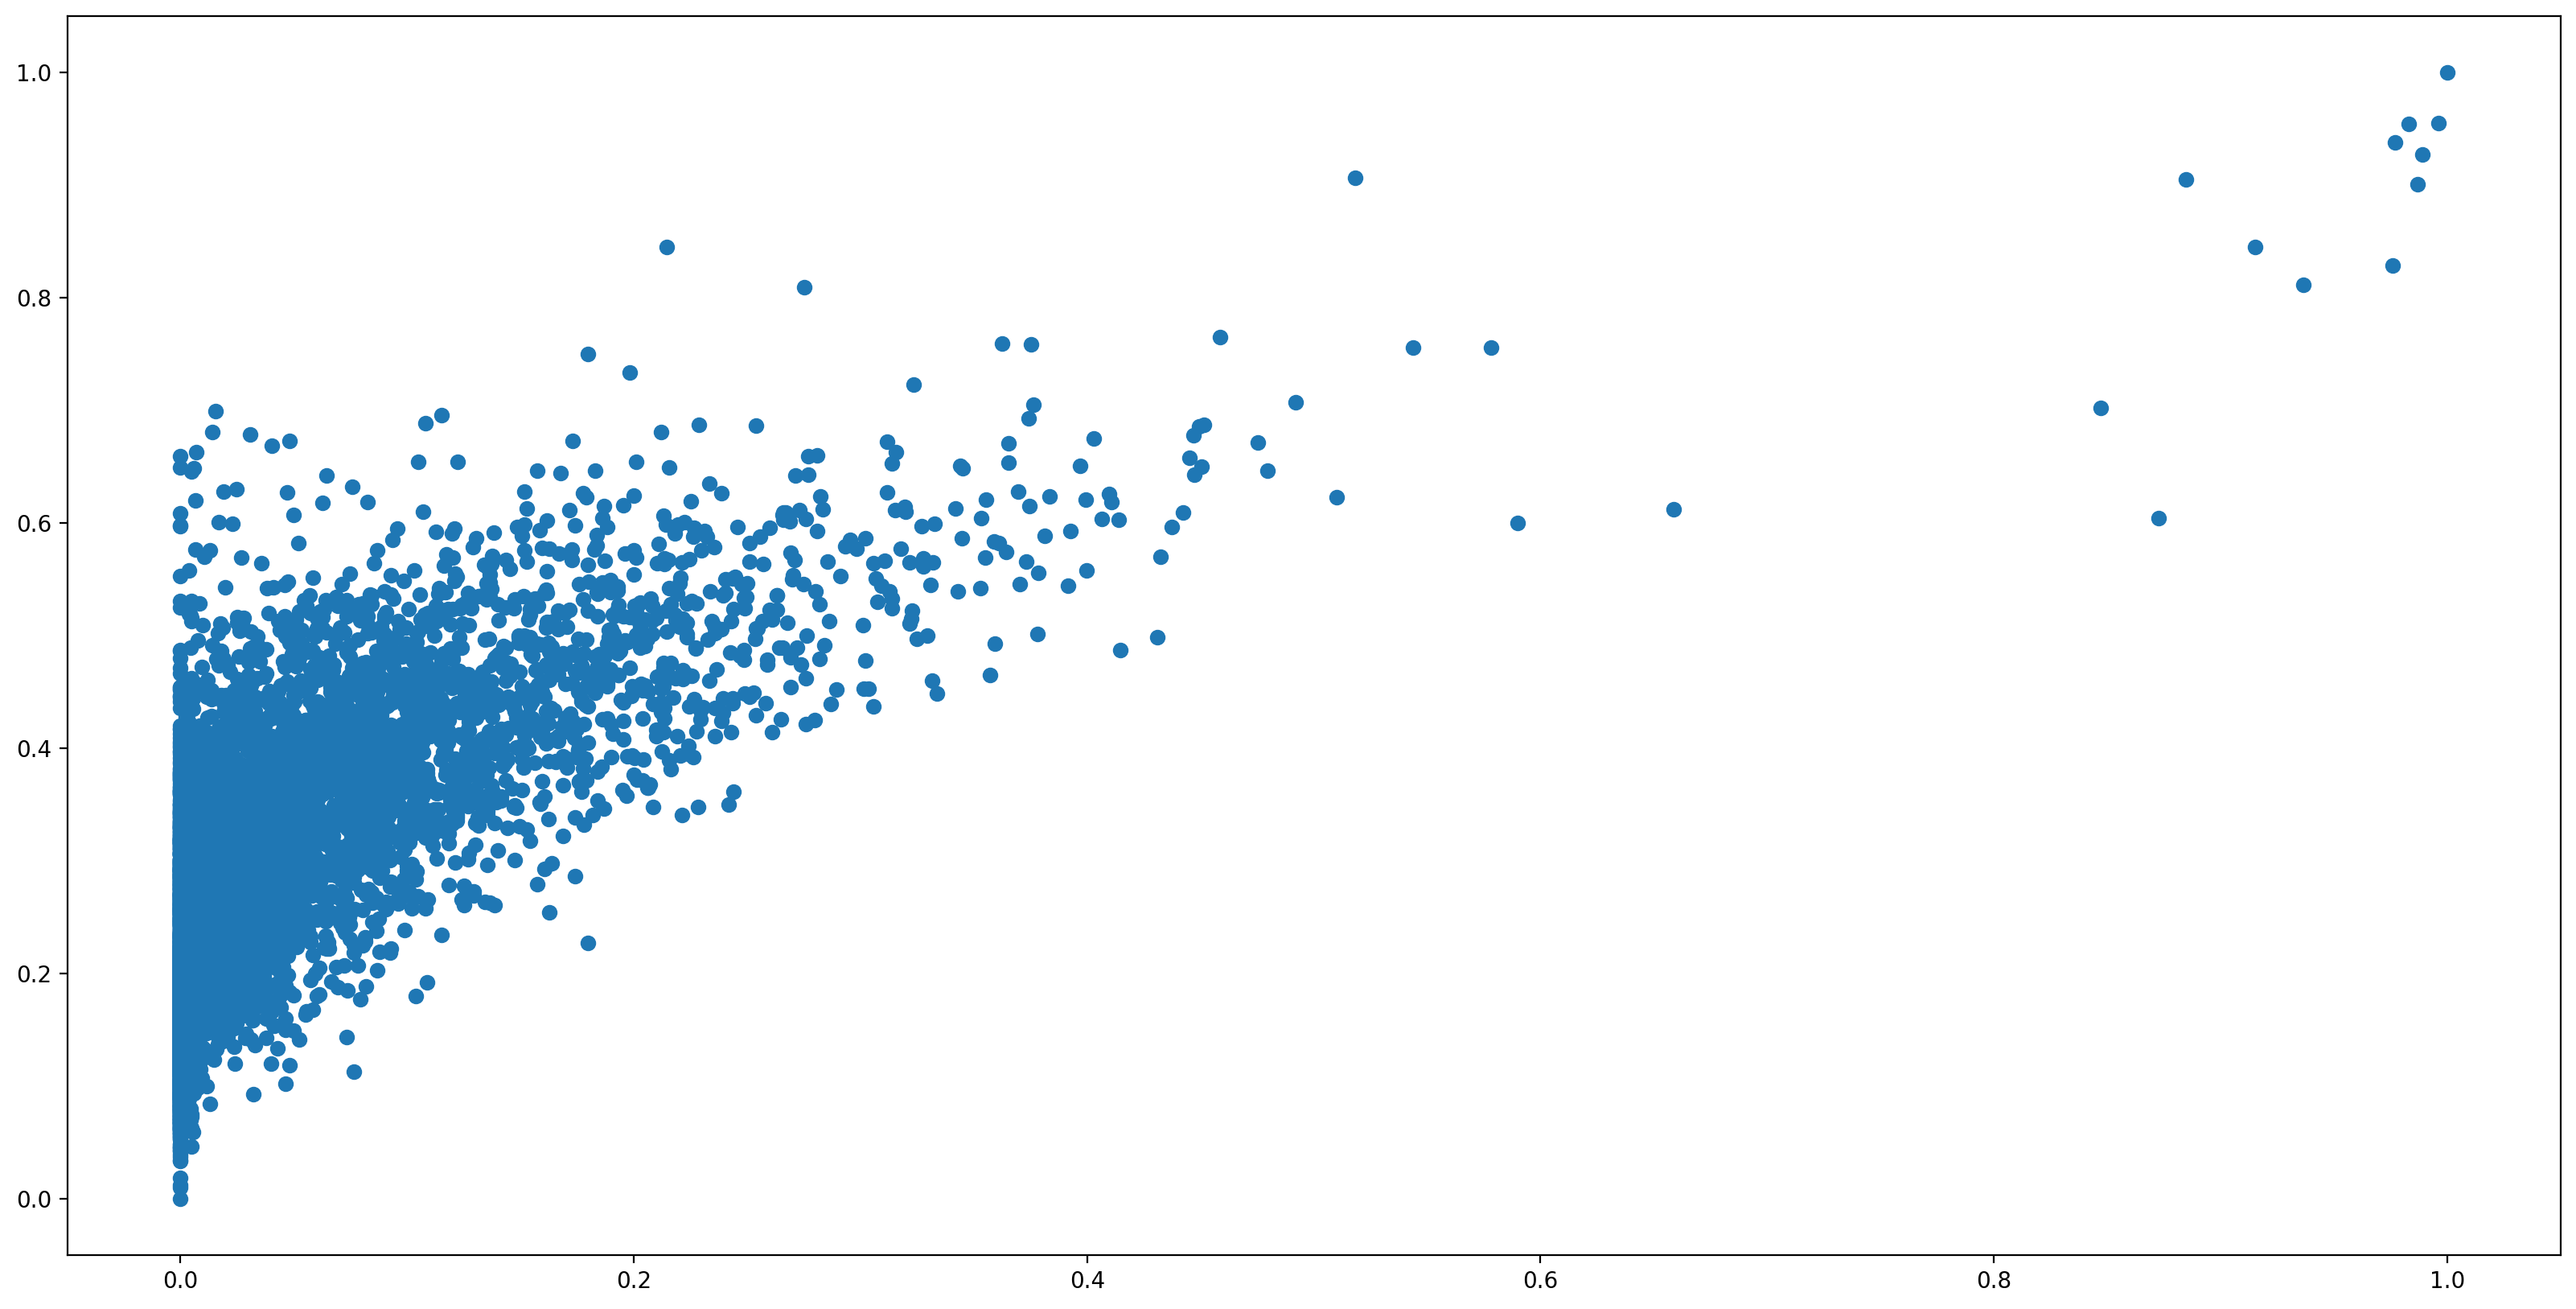

In [13]:
plt.figure(figsize=(20,10), dpi=200)
plt.scatter(train_df[:,0], train_df[:,1])
#plt.plot(train_df[:,0], train_df[:,2])
plt.show()

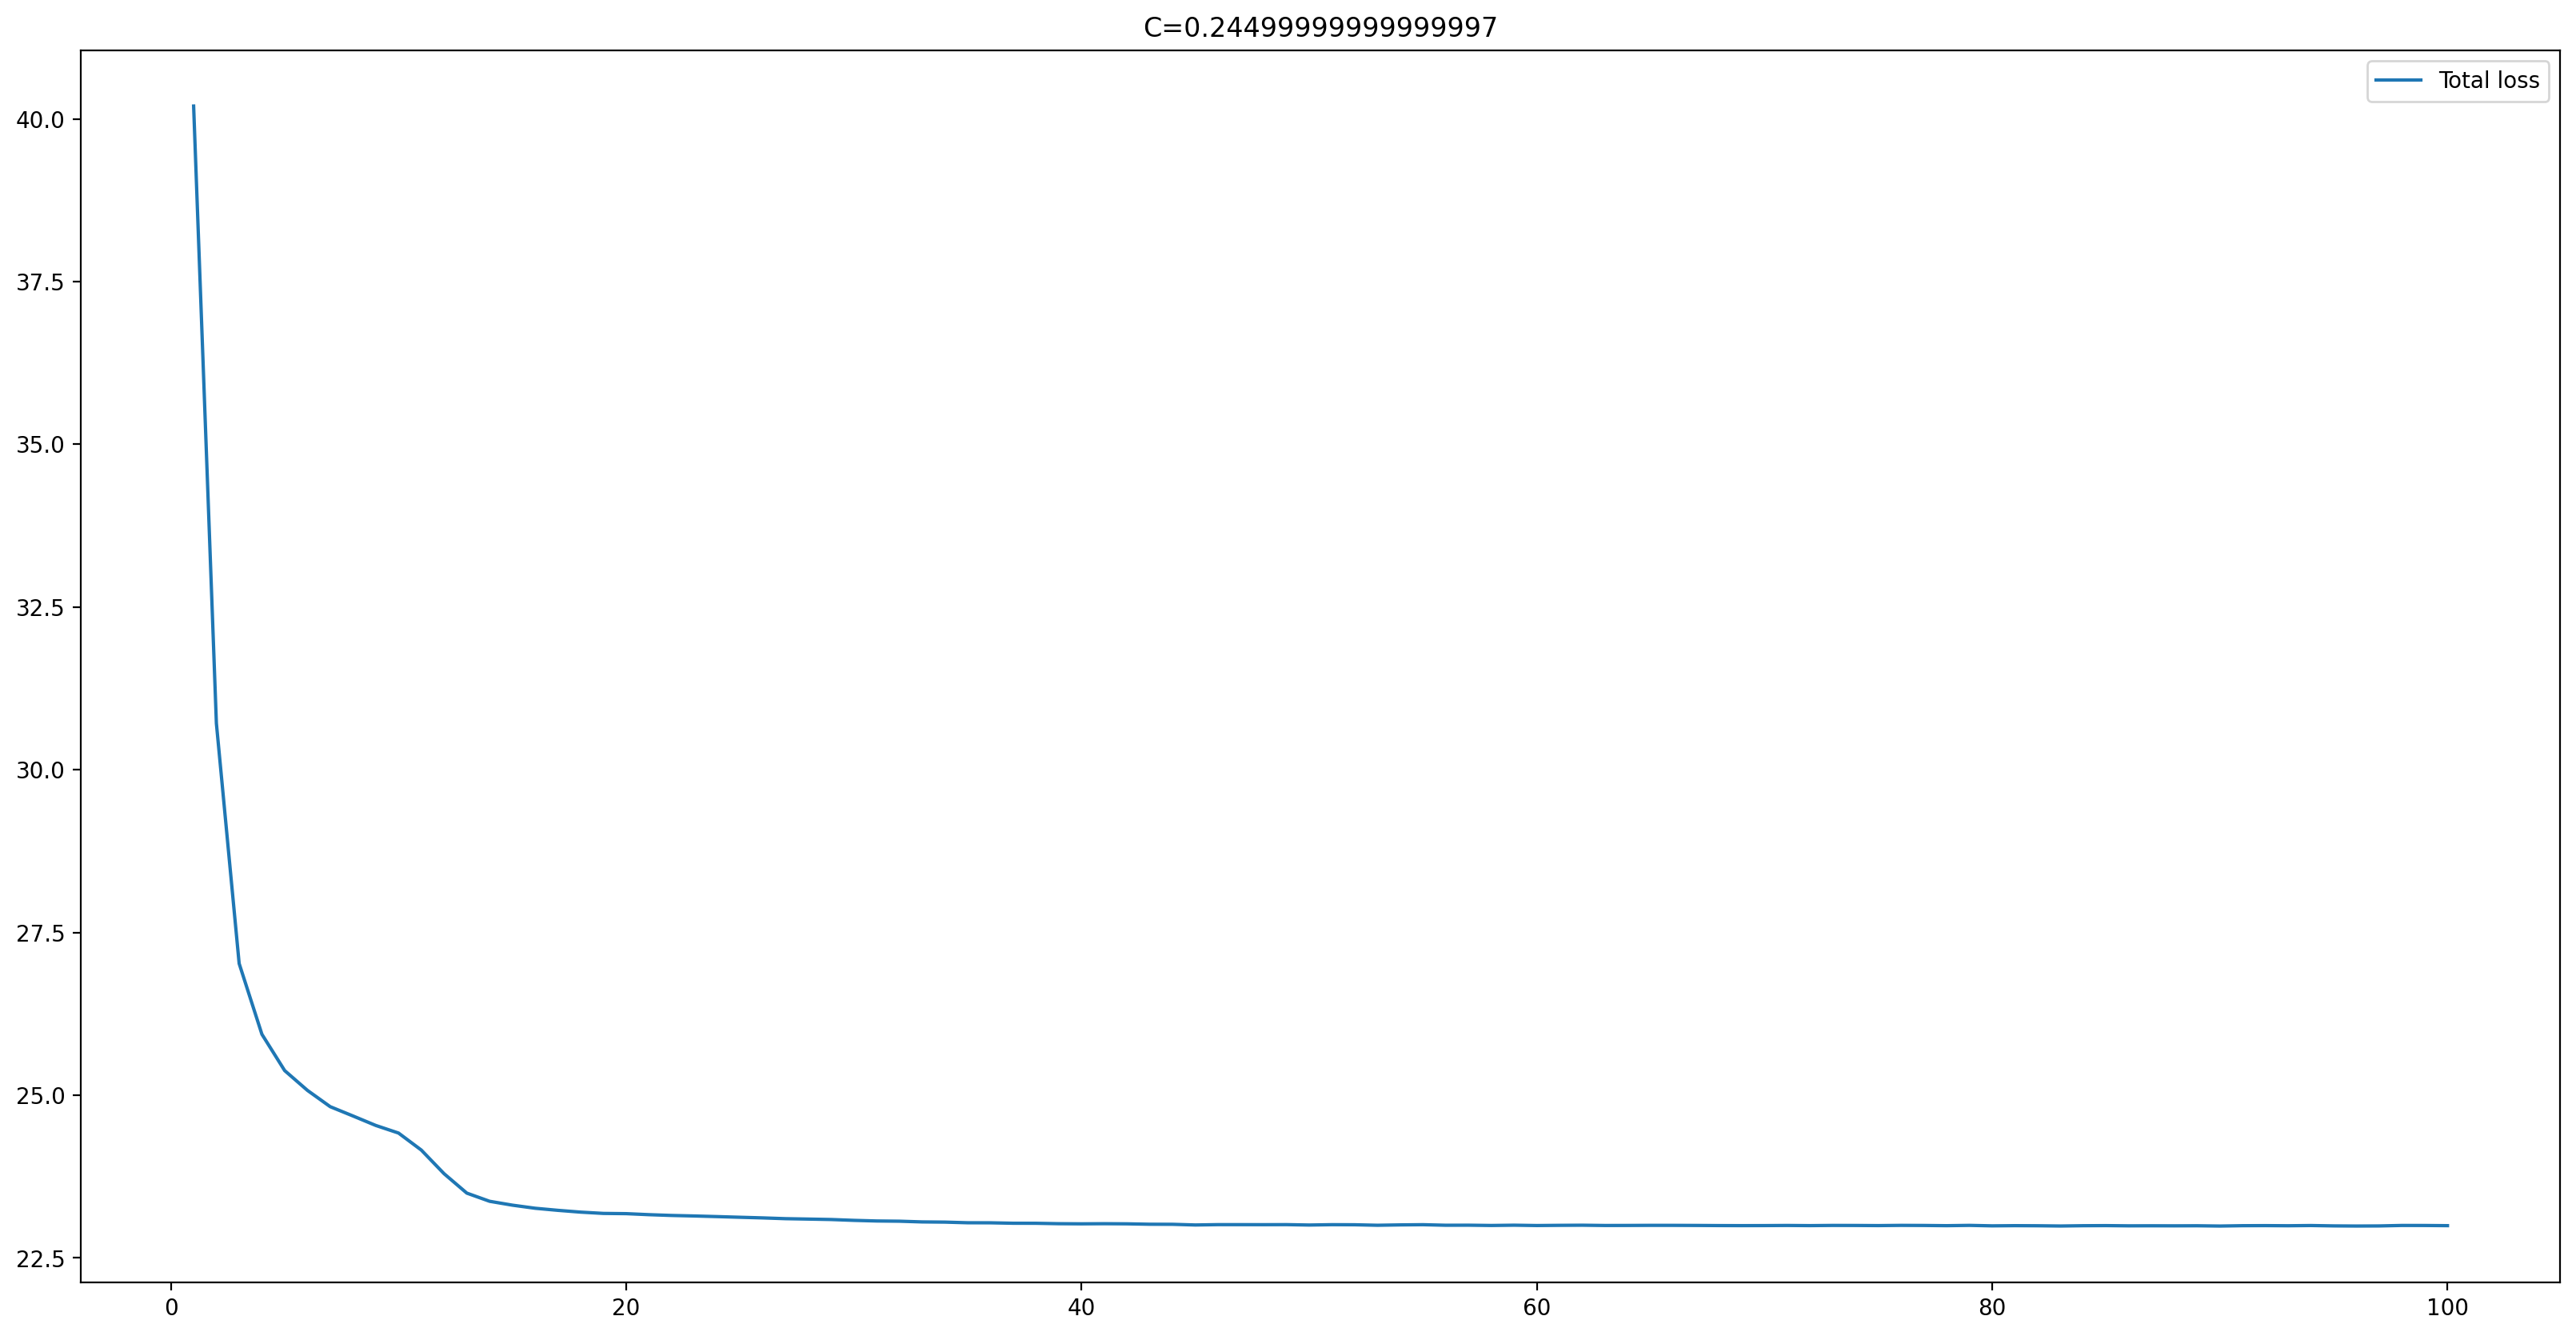

207/207 [==============================] - 0s 384us/step


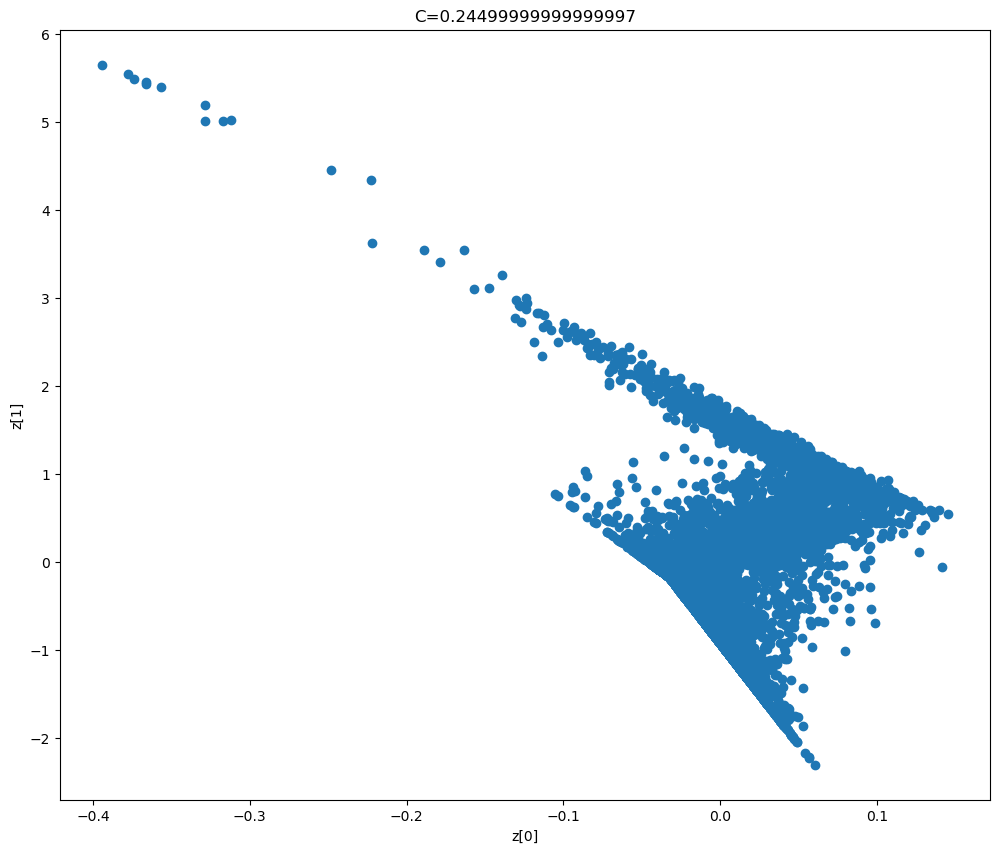

In [38]:
for c in np.arange(0.01,0.25,0.005):
    clear_output(wait=True)
    vae = VAE(input_dim=np.size(train_df, 1), latent_dim=2, C=float(c))
    vae.compile(optimizer=keras.optimizers.Adam())
    earlyStop = keras.callbacks.EarlyStopping(patience=10, mode='min', monitor='loss')
    train_history = vae.fit(train_df, epochs=300, batch_size=64, use_multiprocessing=True, verbose=0, callbacks=[earlyStop])

    tmp = pd.DataFrame(train_history.history)
    tmp['Epocs'] = tmp.index+1

    plt.figure(figsize=(20, 10), dpi=200)
    plt.plot(tmp.Epocs, tmp.loss, '-', label='Total loss')
    plt.legend()
    plt.title(f'C={vae.C}')
    plt.show()

    z_mean, _, z = vae.encoder.predict(train_df)

    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    #plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f'C={vae.C}')
    plt.show()

    new_df = vae.decoder(z)
    new_df = dc.revertToOriginalValue(new_df.numpy())

    plt.figure(figsize=(20,10), dpi=200)
    plt.scatter(data[:,0], data[:,1], color='red', label='Real')
    plt.scatter(new_df[:,0], new_df[:,1], color='blue', label='Synthetic')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Heart rate')
    plt.title(f'C={vae.C}')
    plt.savefig(f'./img/V3_vae/C_{round(vae.C,3)}.png')
    plt.close()
    
    del[vae]